# 03-122 : F1 metric

Building on the work from `03-201` do the set of experiments again, but instead of using `accuracy` as the metric, use `tfa.metrics.F1Score(name='f1_score', num_classes=2, threshold=0.5, average='macro')` which finally allows us to get scores inline to that used in the competition.

In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import sys
import logging
from typing import Tuple
import copy

import pandas as pd

import mlflow
import mlflow.keras

import tensorflow as tf
import tensorflow_addons as tfa
import keras as k
import kerastuner as kt

from competition import source_data as sd
from competition import data_preparation as dp
from competition import feature_engineering as fe
from competition import model_data as md
from competition import model_training as mt
from competition import model_layers as ml
from competition import model_definitions as mm

import seaborn as sns
import matplotlib.pyplot as plt

### Configure Logging

In [3]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-03-28 07:07:40 INFO     Started


## Data Collection

In [4]:
# load the source training set
df_source = sd.read_csv('../data/train.csv.gz',
                        compression='gzip',
                        dtype=sd.source_dtype)

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [5]:
# load the source training labels
df_source_labels = sd.read_csv('../data/train_labels.csv')

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Data Preparation & Cleaning

In [6]:
# prepare the main dataset
df_source = dp.prepare_main_dataset(df_source,
                                    elapsed_time_min_clip=0,
                                    elapsed_time_max_clip=3691298)

# remove sessions with problems
problem_sessions = dp.find_problem_sessions(df_source)
df_source = df_source[~df_source['session_id'].isin(problem_sessions)]

In [7]:
# prepare the label dataset
df_source_labels = dp.prepare_label_dataset(df_source_labels)

# remove sessions with problems
df_source_labels = df_source_labels[~df_source_labels['session_id'].isin(problem_sessions)]

## Feature Engineering

In [8]:
# create the initial features
df_features = fe.create_initial_features(df_source, df_source_labels)

In [9]:
# add the feature to the features dataset
df_features = fe.add_elapsed_time_features(
    features=df_features,
    X=df_source)

In [10]:
# add the total count features to the features dataset
df_features = fe.add_count_total_features(
    features=df_features,
    X=df_source)

In [11]:
# add the unique count features to the features dataset
df_features = fe.add_count_unique_features(
    features=df_features,
    X=df_source)

## Data Selection

In [12]:
random_state = 51

In [13]:
# split the dataset into train, validation and test sets
train, val, test = md.select_sessions(
    y=df_source_labels,
    random_state=random_state,
    test_size=0.60,
    train_size=0.75)

Train: 3495
Validation: 1165
Test: 6988


## Model Training

### Create Datasets

In [14]:
# set the feature list
feature_list = ['elapsed_time_sum', 'elapsed_time_max', 'elapsed_time_min', 'elapsed_time_mean', 'elapsed_time_mode']

# create the simple model dataset
simple_model_dataset = md.get_feature_dataset(
    features=df_features,
    y=df_source_labels,
    feature_list=feature_list,
    train=train,
    val=val,
    test=test,
    include_question=True,
    expand_question=False)

2023-03-28 07:08:59 INFO     -- Creating the train dataset
2023-03-28 07:08:59 INFO     Creating the dataset for all level groups


  0%|          | 0/62910 [00:00<?, ?it/s]

2023-03-28 07:10:15 INFO     -- Creating the val dataset
2023-03-28 07:10:15 INFO     Creating the dataset for all level groups


  0%|          | 0/20970 [00:00<?, ?it/s]

2023-03-28 07:10:42 INFO     -- Creating the test dataset
2023-03-28 07:10:42 INFO     Creating the dataset for all level groups


  0%|          | 0/125784 [00:00<?, ?it/s]

In [15]:
# convert the labels for multi-label classification
cat_simple_model_dataset = md.labels_to_categorical(simple_model_dataset)

In [16]:
# define the simple model input shape
input_data = cat_simple_model_dataset['train']['X']
simple_model_shape = input_data.shape[1]
print('simple_model_shape:', simple_model_shape)

# define the output shape
output_data = cat_simple_model_dataset['train']['y']
simple_model_output_shape = 2
print('output_shape', simple_model_output_shape)

simple_model_shape: 23
output_shape 2


### Training

#### f1_trial_01

In [17]:
# create the experiment
mlflow.set_experiment("f1_trial_01")

<Experiment: artifact_location='file:///home/jfoul001/code/dsm150-2022-oct/cw02/phase_03/mlruns/430002631076462435', creation_time=1679986632923, experiment_id='430002631076462435', last_update_time=1679986632923, lifecycle_stage='active', name='f1_trial_01', tags={}>

In [24]:
# create the hyperparameter object
def define_tune_parameters(hp):
    hp.Int('dense_layer_count', min_value=1, max_value=20, step=1)
    hp.Int('dense_units', min_value=640, max_value=1700, step=32)
    hp.Choice('dense_activation', values=['relu', 'tanh', 'LeakyReLU'])
    hp.Float('dense_l1_regulization', min_value=0.0, max_value=0.0005, step=0.00001)
    hp.Float('dense_l2_regulization', min_value=0.0, max_value=0.001, step=0.0001)
    hp.Float('dense_dropout', min_value=0.005, max_value=0.1, step=0.005)
    hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])

# find the best model
model = mm.tune_simple_dense_model(
    define_tune_parameters=define_tune_parameters,
    dataset=cat_simple_model_dataset,
    max_trials=1000,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count='dense_layer_count',
    dense_units='dense_units',
    dense_activation='dense_activation',
    dense_l1_regulization='dense_l1_regulization',
    dense_l2_regulization='dense_l2_regulization',
    dense_dropout='dense_dropout',
    train_epochs=50,
    train_batch_size=4000,
    train_optimizer=k.optimizers.Adam,
    train_learning_rate='learning_rate',
    train_loss='binary_crossentropy',
    train_metrics=[tfa.metrics.F1Score(name='f1_score', num_classes=2, threshold=0.5, average='macro')],
    train_class_weight=None,
    tune_objective='val_f1_score',
    tune_direction='max')

model.summary()


Trial 4 Complete [00h 05m 54s]
val_f1_score: 0.41468724608421326

Best val_f1_score So Far: 0.6219016909599304
Total elapsed time: 00h 22m 00s
2023-03-28 08:22:25 INFO     on_trial_begin

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
17                |15                |dense_layer_count
640               |1024              |dense_units
tanh              |relu              |dense_activation
0.00019           |5e-05             |dense_l1_regulization
0.0009            |0                 |dense_l2_regulization
0.03              |0.01              |dense_dropout
1e-05             |0.0001            |learning_rate

2023-03-28 08:22:26 INFO     Creating simple dense model
Epoch 1/50
16/16 [==============================] - 6s 232ms/step - loss: 52.5674 - f1_score: 0.5172 - val_loss: 52.4146 - val_f1_score: 0.4306
Epoch 2/50
16/16 [==============================] - 3s 197ms/step - loss: 52.2878 - f1_score: 0.4356 - val_loss: 52.1339 - val_f1_score: 0.4147
Ep

KeyboardInterrupt: 

#### f1_trial_02

In [51]:
mlflow.end_run()

In [52]:
# create the experiment
mlflow.set_experiment("f1_trial_02")

<Experiment: artifact_location='file:///home/jfoul001/code/dsm150-2022-oct/cw02/phase_03/mlruns/410378506255388213', creation_time=1679991794114, experiment_id='410378506255388213', last_update_time=1679991794114, lifecycle_stage='active', name='f1_trial_02', tags={}>

2023-03-28 09:05:23 INFO     Creating simple dense model
2023-03-28 09:05:23 INFO     on_trial_begin

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
2                 |?                 |dense_layer_count
800               |?                 |dense_units
relu              |?                 |dense_activation
0.00011           |?                 |dense_l1_regulization
0.0002            |?                 |dense_l2_regulization
0.02              |?                 |dense_dropout
1e-05             |?                 |learning_rate

2023-03-28 09:05:24 INFO     Creating simple dense model
Epoch 1/50
16/16 [==============================] - 1s 50ms/step - loss: 3.0924 - f1_score: 0.4803 - val_loss: 3.0803 - val_f1_score: 0.3971
Epoch 2/50
16/16 [==============================] - 1s 42ms/step - loss: 3.0711 - f1_score: 0.4130 - val_loss: 3.0595 - val_f1_score: 0.4147
Epoch 3/50
16/16 [==============================] - 1s 33ms/step - loss: 3.0512 - f1_score: 0.

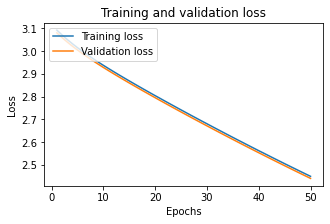

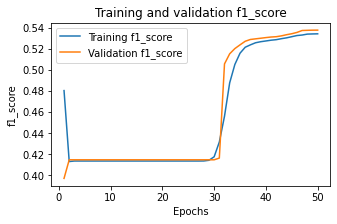

2785/3931 [====================>.........] - ETA: 2s

In [53]:
# create the hyperparameter object
def define_tune_parameters(hp):
    hp.Int('dense_layer_count', min_value=1, max_value=10, step=1)
    hp.Int('dense_units', min_value=256, max_value=1024, step=32)
    hp.Choice('dense_activation', values=['relu', 'tanh', 'LeakyReLU'])
    hp.Float('dense_l1_regulization', min_value=0.0, max_value=0.0005, step=0.00001)
    hp.Float('dense_l2_regulization', min_value=0.0, max_value=0.001, step=0.0001)
    hp.Float('dense_dropout', min_value=0.005, max_value=0.1, step=0.005)
    hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])

# find the best model
model = mm.tune_simple_dense_model(
    define_tune_parameters=define_tune_parameters,
    dataset=cat_simple_model_dataset,
    max_trials=1000,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count='dense_layer_count',
    dense_units='dense_units',
    dense_activation='dense_activation',
    dense_l1_regulization='dense_l1_regulization',
    dense_l2_regulization='dense_l2_regulization',
    dense_dropout='dense_dropout',
    train_epochs=50,
    train_batch_size=4000,
    train_optimizer=k.optimizers.Adam,
    train_learning_rate='learning_rate',
    train_loss='categorical_crossentropy',
    train_metrics=[tfa.metrics.F1Score(name='f1_score', num_classes=2, threshold=0.5, average='macro')],
    train_class_weight=None,
    tuner_type=kt.tuners.BayesianOptimization,
    tune_objective='val_f1_score',
    tune_direction='max')

model.summary()
